In [8]:
#Importamos las librerias necesarias para el análisis de datos 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
#Importamos plotly para la visualización de los datos
import plotly.express as px
import plotly.graph_objects as go


In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error

In [10]:
listing = pd.read_csv(r'C:\Users\spide\Desktop\Bootcamp\mi_entorno\Moodulo_2\Proyecto_final_modulo_2\Data_paris_septiembre\listings3.csv.gz')
calendar = pd.read_csv(r'C:\Users\spide\Desktop\Bootcamp\mi_entorno\Moodulo_2\Proyecto_final_modulo_2\Data_paris_septiembre\calendar.csv.gz')


C:\Users\spide\AppData\Local\Temp\ipykernel_17068\3586152030.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv(r'C:\Users\spide\Desktop\Bootcamp\mi_entorno\Moodulo_2\Proyecto_final_modulo_2\Data_paris_septiembre\calendar.csv.gz')


In [11]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# PRE-PROCESAMIENTO

In [12]:
#Tamaño de mi tabla
print(listing.shape)
print(calendar.shape)

#Visualizamos las primeras filas de la tabla
print(listing.head())
print(calendar.head())


(95461, 75)
(34842829, 7)
       id                          listing_url       scrape_id last_scraped  \
0    3109    https://www.airbnb.com/rooms/3109  20240906025355   2024-09-11   
1    5396    https://www.airbnb.com/rooms/5396  20240906025355   2024-09-13   
2    7397    https://www.airbnb.com/rooms/7397  20240906025355   2024-09-06   
3    7964    https://www.airbnb.com/rooms/7964  20240906025355   2024-09-10   
4  241715  https://www.airbnb.com/rooms/241715  20240906025355   2024-09-11   

            source                                               name  \
0      city scrape                                       zen and calm   
1      city scrape       Your perfect Paris studio on Île Saint-Louis   
2      city scrape                   MARAIS - 2ROOMS APT - 2/4 PEOPLE   
3  previous scrape                       Sunny apartment with balcony   
4      city scrape  Big Cosy Appartement with 100 m2 Terrace in Paris   

                                         description  \
0  L

Creamos un dataframe con las columnas de listing que usaremos para nuestro estudio

In [13]:
df = listing[['id','listing_url','latitude','longitude','name','host_id','host_name','host_url','has_availability','host_since','neighbourhood_cleansed','room_type','accommodates', 'host_is_superhost', 'bathrooms', 'bathrooms_text', 'bedrooms','beds','price', 'minimum_nights','maximum_nights','number_of_reviews'
              ,'instant_bookable','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','host_total_listings_count']]

In [14]:
df.shape

(95461, 31)

In [15]:

(df.isnull().sum()/df.shape[0])*100

id                              0.000000
listing_url                     0.000000
latitude                        0.000000
longitude                       0.000000
name                            0.000000
host_id                         0.000000
host_name                       0.006285
host_url                        0.000000
has_availability                5.100512
host_since                      0.006285
neighbourhood_cleansed          0.000000
room_type                       0.000000
accommodates                    0.000000
host_is_superhost               2.411456
bathrooms                      32.724359
bathrooms_text                  0.094279
bedrooms                        7.757095
beds                           32.851112
price                          32.715978
minimum_nights                  0.000000
maximum_nights                  0.000000
number_of_reviews               0.000000
instant_bookable                0.000000
review_scores_rating           28.432554
review_scores_ac

<Axes: >

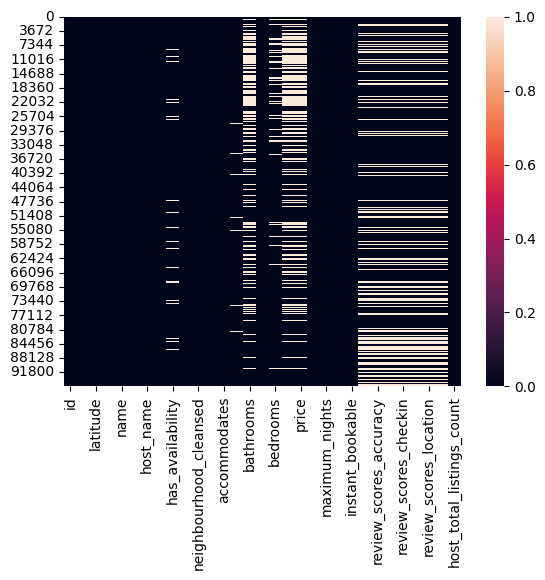

In [16]:
sns.heatmap(df.isnull(), cbar=True)

Arreglamos bathrooms mediante bathrooms_text, vemos que bathrooms_text es la misma variable solo que junto a una palabra, crearemos una nueva columna que sea el split de ese string por el delimitador que toque y llenaremos la anterior con el que sea numero.


In [17]:
df[['bathrooms','bathrooms_text']].iloc[4:15]

,bathrooms,bathrooms_text
4,1.0,1 bath
5,NaN,1 bath
6,NaN,1 bath
7,NaN,1.5 baths
8,1.0,1 bath
9,1.0,1 bath
10,1.0,1 bath
11,1.0,1 bath
12,NaN,1 bath
13,1.0,1 bath


In [18]:
# Función para quedarse con el numero de baños en la cadena de texto de 'bathrooms_text'
def parse_bathrooms(text):
    if pd.isna(text):  # Si es nulo, devolver NaN
        return np.nan
    text = text.lower()
    if 'half' in text:  # Si contiene 'half', devolver 0.5
        return 0.5
    try:
        return float(text.split(' ')[0])  # Tomar el número inicial
    except ValueError:
        return np.nan  # Si no se puede interpretar, devolver NaN

# Aplicar la función a 'bathrooms_text'
df['bathrooms_1'] = df['bathrooms_text'].apply(parse_bathrooms)

# Eliminar la columna Bathroom_text
df = df.drop(columns='bathrooms_text')

# Comprobar si hay valores nulos en 'bathrooms_1' y en caso de que sí, rellenarlos con los valores de 'bathrooms'
df['bathrooms_1'] = df.apply(
    lambda row: row['bathrooms'] if pd.isna(row['bathrooms_1']) and pd.notna(row['bathrooms']) else row['bathrooms_1'],
    axis=1
)

#Eliminamos bathrooms 
df = df.drop(columns='bathrooms')

#Cambiamos el nombre de bathrooms_1 a bathrooms
df = df.rename(columns={'bathrooms_1': 'bathrooms'})

#Eliminamos las filas con valores nulos en bathrooms
df = df.dropna(subset=['bathrooms'])




C:\Users\spide\AppData\Local\Temp\ipykernel_17068\1514636076.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bathrooms_1'] = df['bathrooms_text'].apply(parse_bathrooms)


Arreglamos las variables de review y eliminamos las filas de las variables que tengan menos de un 1% de nulos.

In [19]:
# Seleccionar las columnas que contienen "review" y llenar los nulos con 'Sin review'
variables_de_review = df.loc[:, df.columns.str.contains("review", case=False)]
df.loc[:, df.columns.str.contains("review", case=False)] = variables_de_review.fillna('0.0') # 0.0 es un valor que no se corresponde con ninguna categoría, sería como 'Sin review'
# pasamos las variables de review a numéricas
for col in variables_de_review.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Eliminar los nulos de las columnas 'host_name' y 'host_since'
df = df.dropna(subset=['host_name', 'host_since'])




C:\Users\spide\AppData\Local\Temp\ipykernel_17068\1082786191.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5.0 4.61 4.73 ... '0.0' '0.0' '0.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.contains("review", case=False)] = variables_de_review.fillna('0.0') # 0.0 es un valor que no se corresponde con ninguna categoría, sería como 'Sin review'
C:\Users\spide\AppData\Local\Temp\ipykernel_17068\1082786191.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5.0 4.64 4.81 ... '0.0' '0.0' '0.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.contains("review", case=False)] = variables_de_review.fillna('0.0') # 0.0 es un valor que no se corresponde con ninguna categoría, sería como 'Sin review'
C:\Users\s

# Arreglo de price mediante la tabla calendar 

Crearemos un dataframe de la media de los precios para cada listing_id de la tabla calendar para tratar de relacionar

In [20]:
# Limpiar la columna 'price' eliminando caracteres no numéricos
calendar['price'] = calendar['price'].str.replace('[\$,]', '', regex=True)

# Convertir a numérico, manteniendo los valores no válidos como NaN
calendar['price'] = pd.to_numeric(calendar['price'], errors='coerce')


In [21]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3109,2024-09-11,f,100.0,NaN,2.0,30.0
1,3109,2024-09-12,f,100.0,NaN,2.0,30.0
2,3109,2024-09-13,f,100.0,NaN,2.0,30.0
3,3109,2024-09-14,f,100.0,NaN,2.0,30.0
4,3109,2024-09-15,f,100.0,NaN,2.0,30.0


In [22]:
calendar.dtypes

listing_id          int64
date               object
available          object
price             float64
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

In [23]:
calendario_para_imputar_precio = calendar.groupby('listing_id')['price'].mean().to_dict()

In [24]:
max_calendario_precio = max(calendario_para_imputar_precio.values())
min_calendario_precio = min(calendario_para_imputar_precio.values())

print(f'El valor máximo de calendario_para_imputar_precio es: {max_calendario_precio}')
print(f'El valor mínimo de calendario_para_imputar_precio es: {min_calendario_precio}')

El valor máximo de calendario_para_imputar_precio es: 901684.0
El valor mínimo de calendario_para_imputar_precio es: 0.0


In [25]:
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [26]:
def imputar_valores(df, calendario_para_imputar_precio):
    # Iterar sobre las filas con valores nulos en 'price'
    for index, row in df[df['price'].isnull()].iterrows():
        # Obtener el listing_id de la fila actual
        listing_id = row['id']
        # Verificar si el listing_id está en el diccionario
        if listing_id in calendario_para_imputar_precio:
            # Sustituir el valor con el valor del diccionario
            df.at[index, 'price'] = calendario_para_imputar_precio[listing_id]
    # Devolver el DataFrame con los valores imputados
    return df['price'].isnull().sum()   # Comprobar si hay valores nulos en 'price'

# Imputar los valores de 'price' en el DataFrame 'df'
imputar_valores(df, calendario_para_imputar_precio)




np.int64(0)

In [27]:
max_price = df['price'].max()
min_price = df['price'].min()

print(f'El valor máximo de price es: {max_price}')
print(f'El valor mínimo de price es: {min_price}')

El valor máximo de price es: 901684.0
El valor mínimo de price es: 0.0


In [28]:
num_filas_superior_10000 = df[df['price'] > 10000].shape[0]
print(f'Número de filas con price superior a 10000: {num_filas_superior_10000}')

Número de filas con price superior a 10000: 25


In [29]:
# Borrar las filas con los valores nulos que no se han podido imputar
df = df.dropna(subset=['price'])

In [30]:
# Borrar las filas con price igual a 0
df = df[df['price'] != 0]

# Borrar las filas con price superior a 10000
df = df[df['price'] < 10000]

In [31]:
df['price'].nlargest(10)

11355    9999.0
12298    9999.0
16268    9999.0
33650    9999.0
33651    9999.0
33652    9999.0
33653    9999.0
33670    9999.0
33671    9999.0
33672    9999.0
Name: price, dtype: float64

# Tratamiento de outliers de price - descartado.

En un inicio iba a ajustar los outliers de price a los cuartiles pero decidí dejarlos ya que nos pueden aportar información valiosa de algunos alquileres

In [32]:
'''# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites inferior y superior para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detectar outliers
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

# Contar la cantidad de outliers
num_outliers = outliers.shape[0]

print(f'Cantidad de outliers en la columna price: {num_outliers}')'''

"# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)\nQ1 = df['price'].quantile(0.25)\nQ3 = df['price'].quantile(0.75)\n\n# Calcular el rango intercuartílico (IQR)\nIQR = Q3 - Q1\n\n# Definir los límites inferior y superior para detectar outliers\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# Detectar outliers\noutliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]\n\n# Contar la cantidad de outliers\nnum_outliers = outliers.shape[0]\n\nprint(f'Cantidad de outliers en la columna price: {num_outliers}')"

In [33]:
'''from scipy.stats import skew

# Aplicar la transformación logarítmica a la variable 'price'
df['log_price'] = np.log(df['price'])

# Calcular el skewness de la variable 'log_price'
log_price_skewness = skew(df['log_price'].dropna())

print(f'Skewness de la variable log_price: {log_price_skewness}')'''

"from scipy.stats import skew\n\n# Aplicar la transformación logarítmica a la variable 'price'\ndf['log_price'] = np.log(df['price'])\n\n# Calcular el skewness de la variable 'log_price'\nlog_price_skewness = skew(df['log_price'].dropna())\n\nprint(f'Skewness de la variable log_price: {log_price_skewness}')"

Price no es simétrico


In [34]:
'''from scipy.stats import shapiro

# Realizar la prueba de Shapiro-Wilk
stat, p_value = shapiro(df['log_price'])

print(f'Estadístico de Shapiro-Wilk: {stat}')
print(f'Valor p: {p_value}')

# Interpretar el resultado
alpha = 0.05
if p_value > alpha:
    print('La variable log_price sigue una distribución normal (no se rechaza H0)')
else:
    print('La variable log_price no sigue una distribución normal (se rechaza H0)')'''

"from scipy.stats import shapiro\n\n# Realizar la prueba de Shapiro-Wilk\nstat, p_value = shapiro(df['log_price'])\n\nprint(f'Estadístico de Shapiro-Wilk: {stat}')\nprint(f'Valor p: {p_value}')\n\n# Interpretar el resultado\nalpha = 0.05\nif p_value > alpha:\n    print('La variable log_price sigue una distribución normal (no se rechaza H0)')\nelse:\n    print('La variable log_price no sigue una distribución normal (se rechaza H0)')"

Price no sigue una distribución normal por lo que los outliers los trataremos según el rango intercuartílico. 

In [35]:
'''import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df, showfliers=False) #Showfliers=False para no mostrar los outliers
plt.xticks(rotation=90)
plt.title("Distribución de precios por barrio")
plt.show()'''


'import seaborn as sns\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(15, 6))\nsns.boxplot(x=\'neighbourhood_cleansed\', y=\'price\', data=df, showfliers=False) #Showfliers=False para no mostrar los outliers\nplt.xticks(rotation=90)\nplt.title("Distribución de precios por barrio")\nplt.show()'

Visualmente se puede notar que hay diferencias entre los precios según el barrio, cosa que era de esperar, pero para tener una justificación matemática realizaremos una preuba de *kruskal-wallis* ya que utiliza los rangos de los datos para determinar si existen diferencias significativas entre las medianas de tres o más grupos de datos. Es como una ANOVA pero para distribuciones no normales.

In [36]:
'''from scipy.stats import kruskal

# Crear listas de precios por barrio
precios_por_barrio = []
for barrio in df['neighbourhood_cleansed'].unique():
    precios_por_barrio.append(df[df['neighbourhood_cleansed'] == barrio]['price'])

# Prueba de Kruskal-Wallis
stat, p_value = kruskal(*precios_por_barrio)
print(f"Estadístico de Kruskal-Wallis: {stat}")
print(f"p-valor: {p_value}")

# Interpretación del p-valor
if p_value < 0.05:
    print("Hay diferencias significativas en el precio entre los barrios.")
else:
    print("No hay diferencias significativas en el precio entre los barrios.")'''


'from scipy.stats import kruskal\n\n# Crear listas de precios por barrio\nprecios_por_barrio = []\nfor barrio in df[\'neighbourhood_cleansed\'].unique():\n    precios_por_barrio.append(df[df[\'neighbourhood_cleansed\'] == barrio][\'price\'])\n\n# Prueba de Kruskal-Wallis\nstat, p_value = kruskal(*precios_por_barrio)\nprint(f"Estadístico de Kruskal-Wallis: {stat}")\nprint(f"p-valor: {p_value}")\n\n# Interpretación del p-valor\nif p_value < 0.05:\n    print("Hay diferencias significativas en el precio entre los barrios.")\nelse:\n    print("No hay diferencias significativas en el precio entre los barrios.")'

Vale ahora ajustaremos los outliers a 1,5*IQR por las siguientes razones: 
* De esta manera preservamos la representatividad de los datos y garantizamos que los valores extremos no distorisionen el análisis. 
* Ajustar los outliers dentro del ocntexto de cada barrio permite capturar mejor las características reales de las propiedades en cada zona. 
* Aseguramos que no se pierdan datos relevantes, manteniendo la diversidad del dataset y minimizamos el impacto que pueden tener estos valores extremos en las recomendaciones.

In [37]:
'''# Creamos una lista con los valores unicos de cada barrio
barrios = df['neighbourhood_cleansed'].unique()

# Iteramos sobre cada barrio para ajustar los outliers
for barrio in barrios:
    # Filtrar los datos del barrio actual
    barrio_data = df[df['neighbourhood_cleansed'] == barrio]
    
    # Calculamos el rango intercuartílico de la variable price para el barrio actual 
    Q1 = barrio_data['price'].quantile(0.25)
    Q3 = barrio_data['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Ajustamos los outliers al límite inferior y superior.
    df.loc[df['neighbourhood_cleansed'] == barrio, 'price'] = barrio_data['price'].clip(lower=lower_bound, upper=upper_bound)

# Verificar los resultados
print(df['price'].describe())'''


"# Creamos una lista con los valores unicos de cada barrio\nbarrios = df['neighbourhood_cleansed'].unique()\n\n# Iteramos sobre cada barrio para ajustar los outliers\nfor barrio in barrios:\n    # Filtrar los datos del barrio actual\n    barrio_data = df[df['neighbourhood_cleansed'] == barrio]\n    \n    # Calculamos el rango intercuartílico de la variable price para el barrio actual \n    Q1 = barrio_data['price'].quantile(0.25)\n    Q3 = barrio_data['price'].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n    \n    # Ajustamos los outliers al límite inferior y superior.\n    df.loc[df['neighbourhood_cleansed'] == barrio, 'price'] = barrio_data['price'].clip(lower=lower_bound, upper=upper_bound)\n\n# Verificar los resultados\nprint(df['price'].describe())"

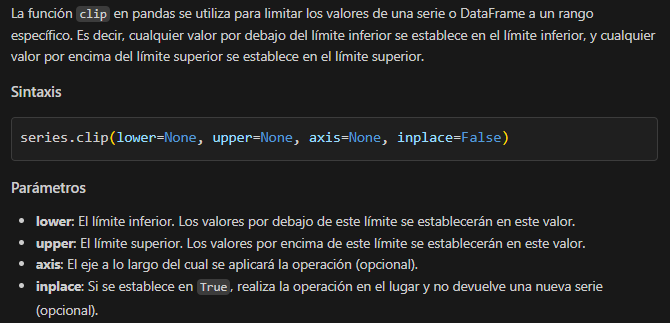

# Fin de tratamiento de outliers de price - descartado

Text(0.5, 1.0, 'Distribución de precios por barrio')

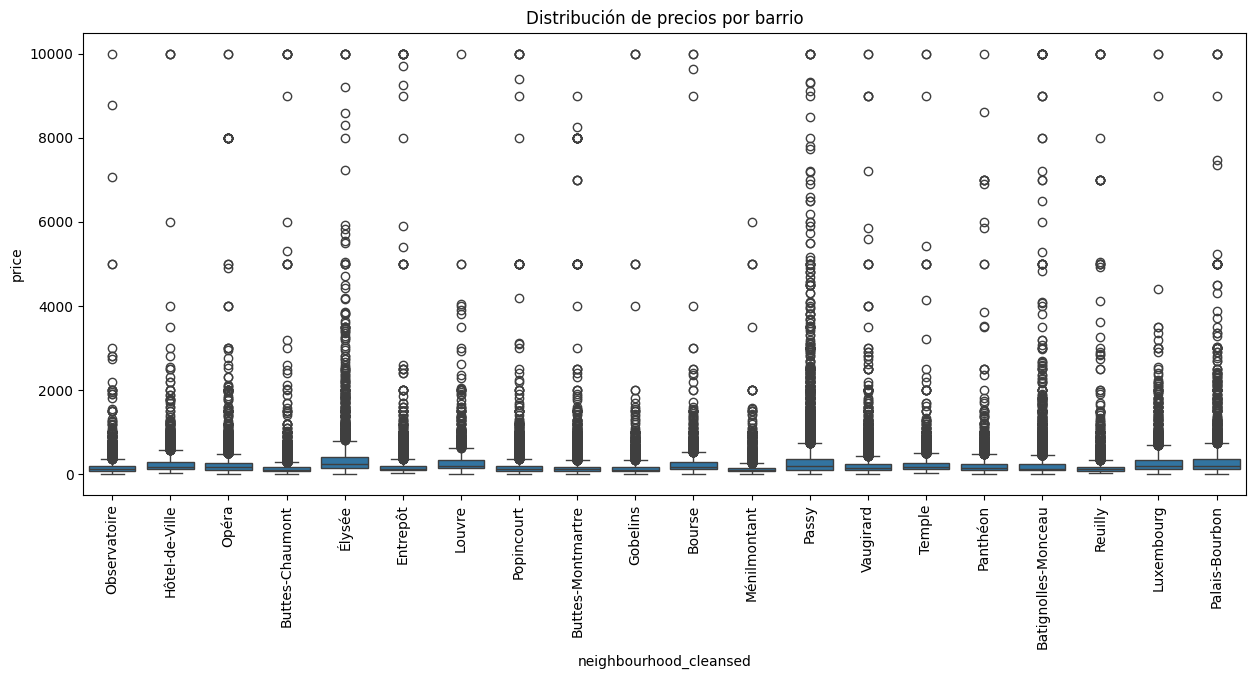

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df, showfliers=True) #Showfliers=False para no mostrar los outliers
plt.xticks(rotation=90)
plt.title("Distribución de precios por barrio")

Encodeamos las variables de instant_bookable

In [39]:
df['instant_bookable'].value_counts()
#Reemplazar por uno los valores 't' y 'f' de la columna 'instant_bookable'
df['instant_bookable'] = df['instant_bookable'].replace({'t': 1, 'f': 0})



C:\Users\spide\AppData\Local\Temp\ipykernel_17068\1876104742.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['instant_bookable'] = df['instant_bookable'].replace({'t': 1, 'f': 0})


Llenamos los nulos de host_is_superhost con falso ya que no podemos asegurar que sean super anfitriones

In [40]:
df['host_is_superhost'].value_counts()
df.fillna({'host_is_superhost': 'f'}, inplace=True)



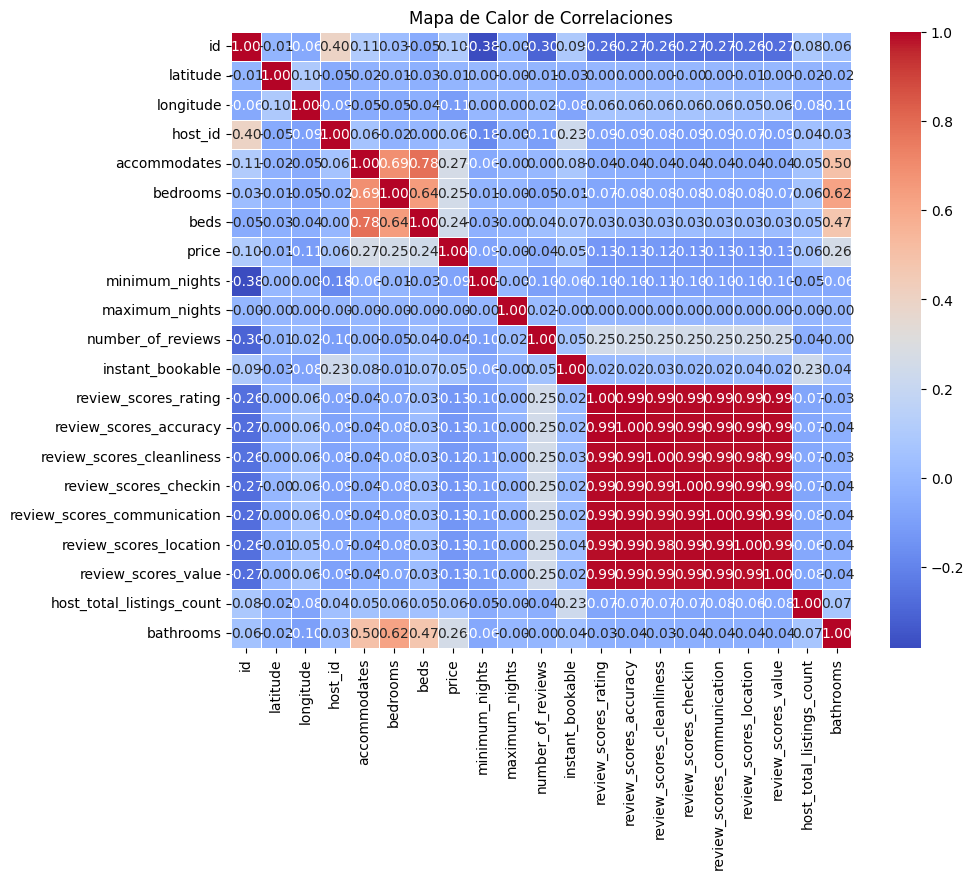

In [41]:
# Seleccionar solo las columnas numéricas
numeric_df = df.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

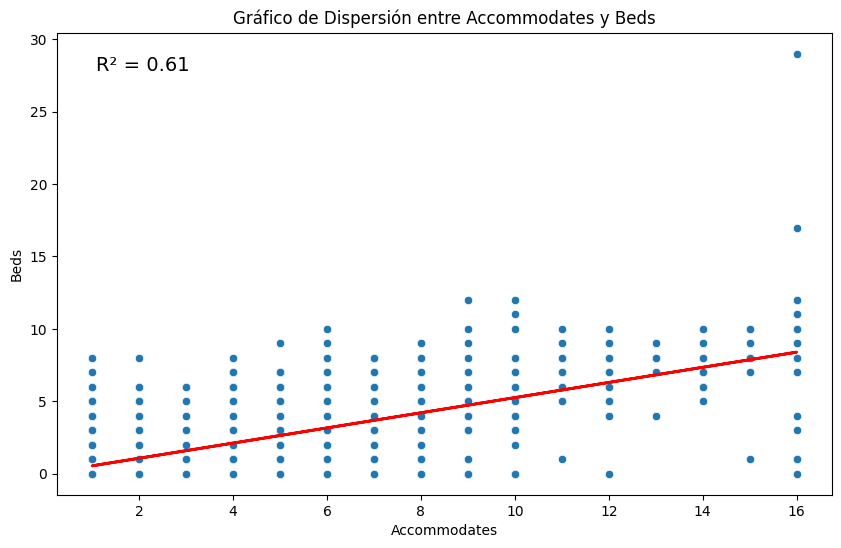

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Filtrar los datos para eliminar filas con valores nulos en 'accommodates' o 'beds'
filtered_df = df.dropna(subset=['accommodates', 'beds'])

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accommodates', y='beds', data=filtered_df)

# Ajustar un modelo de regresión lineal
X = filtered_df[['accommodates']]
y = filtered_df['beds']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calcular el valor de R²
r2 = r2_score(y, y_pred)

# Dibujar la línea de regresión
plt.plot(filtered_df['accommodates'], y_pred, color='red', linewidth=2)

# Mostrar el valor de R² en el gráfico
plt.text(0.05, 0.95, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

plt.title('Gráfico de Dispersión entre Accommodates y Beds')
plt.xlabel('Accommodates')
plt.ylabel('Beds')
plt.show()

In [43]:
# Filtrar las correlaciones positivas de 'beds' y 'bedrooms' que estén por encima de 0.5
correlaciones_beds = correlation_matrix['beds'][(correlation_matrix['beds'] > 0.5) & (correlation_matrix['beds'] < 1)]
correlaciones_bedrooms = correlation_matrix['bedrooms'][(correlation_matrix['bedrooms'] > 0.5) & (correlation_matrix['bedrooms'] < 1)]

print("Correlaciones positivas de 'beds' por encima de 0.5:")
print(correlaciones_beds)

print("\nCorrelaciones positivas de 'bedrooms' por encima de 0.5:")
print(correlaciones_bedrooms)

Correlaciones positivas de 'beds' por encima de 0.5:
accommodates    0.781674
bedrooms        0.644353
Name: beds, dtype: float64

Correlaciones positivas de 'bedrooms' por encima de 0.5:
accommodates    0.689725
beds            0.644353
bathrooms       0.620154
Name: bedrooms, dtype: float64


In [44]:
df['neighbourhood_cleansed']

0               Observatoire
1             Hôtel-de-Ville
2             Hôtel-de-Ville
3                      Opéra
4            Buttes-Chaumont
                ...         
95456                  Passy
95457    Batignolles-Monceau
95458                 Temple
95459      Buttes-Montmartre
95460               Panthéon
Name: neighbourhood_cleansed, Length: 95376, dtype: object

Vamos a usar un modelo de k-NN para imputar los nulos de bedrooms usando las variables accommodates, bathrooms,price y neighbourhood_cleansed encodeado con un one-hot encoder.

In [45]:
#Paso 1: Seleccionar las columnas que se van a utilizar para el modelo
# Columnas para predecir la variable bedrooms
columns_to_use = ['accommodates', 'bathrooms', 'price', 'neighbourhood_cleansed', 'bedrooms']

# Paso 2: Crear un DataFrame con las columnas seleccionadas 
# creamos un dataframe con las columnas seleccionadas
df_knn = df[columns_to_use].copy()

from sklearn.preprocessing import OneHotEncoder

#Paso 3: Encodear las variables categóricas en un nuevo dataframe
# Encodeamos los barrios con un OneHot encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Evita errores con categorías desconocidas
encoded_neighbourhoods = encoder.fit_transform(df_knn[['neighbourhood_cleansed']])

# Crear un DataFrame con las columnas codificadas
encoded_neighbourhoods_df = pd.DataFrame(
    encoded_neighbourhoods,
    columns=encoder.get_feature_names_out(['neighbourhood_cleansed'])
)
'''Ponemos la variable de barrios encodeada en un dataframe nuevo porque el one hot encoder no conserva
 automáticamente los índices originales del dataframe. Por lo que creamos el nuevo dataframe y después concatenaremosç
 este dataframe con el dataframe original para tener todas las variables juntas.'''

#Paso 4: Concatenar encoded_neighbourhoods_df con df_knn

'''El primer paso es asegurarse de que los índices de ambos dataframes coincidan, para ello
usamos el método reset_index() para resetear los índices de ambos dataframes y después concatenarlos.'''

df_knn = df_knn.reset_index(drop=True) 
encoded_neighbourhoods_df = encoded_neighbourhoods_df.reset_index(drop=True)
#Concatenamos encoded_neighbourhoods_df con df_knn
# Concatenar las columnas codificadas al DataFrame original
df_knn = pd.concat([df_knn.drop(columns=['neighbourhood_cleansed']), encoded_neighbourhoods_df], axis=1)

#Paso 5: dividir el dataframe en variables de entrenamiento y variables de prueba
train_data = df_knn[df_knn['bedrooms'].notnull()]
test_data = df_knn[df_knn['bedrooms'].isnull()]

#Separar las características (X) y variables objetivos (Y)
X_train = train_data.drop(columns='bedrooms')
y_train = train_data['bedrooms']
X_test = test_data.drop(columns='bedrooms')

#Paso opcional: Escalar las características

'''El algorítmo kNN se basa en la distáncia euclidiana entre los puntos, por lo que es crucial 
que todas las características contribuyan de manera equitativa a esta distáncia. 

Por ejemplo: Si una característica tiene valores en el rango de 1 a 10 y otra en el rango de 1000 a 10000, 
la segunda característica dominará la distancia euclidiana, haciendo que la primera característica tenga poco 
impacto en la clasificación.

También mejora la precisión y la eficiencia del modelo. Por lo que es recomendable escalar las características.'''


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Creamos el objeto escalador
X_train_scaled = scaler.fit_transform(X_train) #Escalamos los datos de entrenamiento y ajustamos el escalador
X_test_scaled = scaler.transform(X_test)        # Transformar datos de prueba

#Paso 6: Encontrar el mejor valor de k.

''' Para encontrar el mejor valor de k debemos:
1) Definir un rango de valores para k.
2) Evaluaremos el desempeño del modelo para cada valor de k con una validación cruzada para calcular el 
error medio cuadrático (RMSE) para cada valor de k.
3) Seleccionar el k con el menor error

Opcional: gráficar en un gráfico de líneas el MSE para visualizar el "codo" y seleccionar el mejor valor de k.'''

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#Definimos el rango de valores de k.
k_range = range(1, 11)  

#Creamos una lista vacía para almacenar los errores promedio para cada valor de k
k_errors = []

#bucle para evaluar el desempeño del modelo para cada valor de k
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    #Calculamos el error medio cuadrático con validación cruzada
    mse = -cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    #Agregamos el error promedio a la lista
    k_errors.append(mse)
# definimos el mejor valor de k
best_k = k_range[np.argmin(k_errors)]

#Paso 7: Entrenar el modelo con el mejor valor de k
knn_model = KNeighborsRegressor(n_neighbors=3) #usamos 7 porque es el valor en el que el error de k empieza a ser constante
#Entrenamiento del modelo
knn_model.fit(X_train_scaled, y_train)

#Paso 8: Predecir los valores faltantes
predicted_bedrooms = knn_model.predict(X_test_scaled)
predicted_bedrooms = predicted_bedrooms.astype(int) # Redondeamos los valores para que sean enteros 
#Paso 9: Reemplazar los valores faltantes en el dataframe original
df.loc[df['bedrooms'].isnull(), 'bedrooms'] = predicted_bedrooms

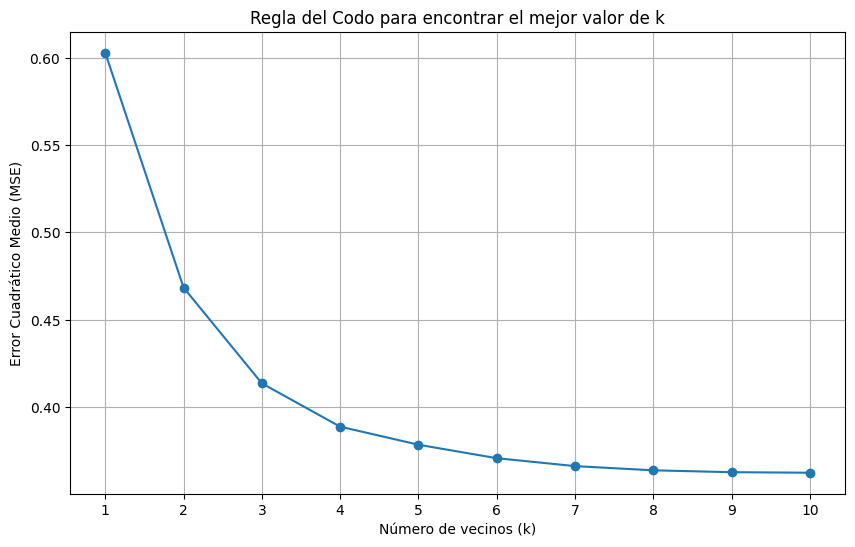

In [46]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_errors, marker='o')
plt.title('Regla del Codo para encontrar el mejor valor de k')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [47]:
df[df['bedrooms']==0][['price','bedrooms','beds','accommodates','bathrooms']].value_counts()

price  bedrooms  beds  accommodates  bathrooms
100.0  0.0       1.0   2             1.0          175
80.0   0.0       1.0   2             1.0          137
90.0   0.0       1.0   2             1.0          130
120.0  0.0       1.0   2             1.0          122
110.0  0.0       1.0   2             1.0           96
                                                 ... 
872.0  0.0       1.0   6             1.0            1
880.0  0.0       1.0   4             1.0            1
893.0  0.0       1.0   2             1.0            1
898.0  0.0       2.0   4             1.0            1
900.0  0.0       0.0   2             1.0            1
Name: count, Length: 1591, dtype: int64

In [48]:
df.loc[63430, ['bedrooms', 'beds', 'price','accommodates']]

bedrooms         0.0
beds             4.0
price           91.0
accommodates       2
Name: 63430, dtype: object

In [49]:
#Por logica siempre tiene que haber mínimo el mismo numero de camas que de viajeros, entonces para aquellos casos 
# en los que accommodates < beds, le daremos el valor de beds.
df.loc[df['beds'] > df['accommodates'], 'accommodates'] = df['beds']

In [50]:
df.columns

Index(['id', 'listing_url', 'latitude', 'longitude', 'name', 'host_id',
       'host_name', 'host_url', 'has_availability', 'host_since',
       'neighbourhood_cleansed', 'room_type', 'accommodates',
       'host_is_superhost', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'instant_bookable',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_total_listings_count', 'bathrooms'],
      dtype='object')

imputamos los nulos de beds

In [51]:
#Paso 1: Seleccionar las columnas que se van a utilizar para el modelo
# Columnas para predecir la variable bedrooms
columns_to_use = ['accommodates', 'bathrooms', 'price', 'neighbourhood_cleansed', 'bedrooms', 'beds']

# Paso 2: Crear un DataFrame con las columnas seleccionadas 
# creamos un dataframe con las columnas seleccionadas
df_knn = df[columns_to_use].copy()

from sklearn.preprocessing import OneHotEncoder

#Paso 3: Encodear las variables categóricas en un nuevo dataframe
# Encodeamos los barrios con un OneHot encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Evita errores con categorías desconocidas
encoded_neighbourhoods = encoder.fit_transform(df_knn[['neighbourhood_cleansed']])

# Crear un DataFrame con las columnas codificadas
encoded_neighbourhoods_df = pd.DataFrame(
    encoded_neighbourhoods,
    columns=encoder.get_feature_names_out(['neighbourhood_cleansed'])
)
'''Ponemos la variable de barrios encodeada en un dataframe nuevo porque el one hot encoder no conserva
 automáticamente los índices originales del dataframe. Por lo que creamos el nuevo dataframe y después concatenaremosç
 este dataframe con el dataframe original para tener todas las variables juntas.'''

#Paso 4: Concatenar encoded_neighbourhoods_df con df_knn

'''El primer paso es asegurarse de que los índices de ambos dataframes coincidan, para ello
usamos el método reset_index() para resetear los índices de ambos dataframes y después concatenarlos.'''

df_knn = df_knn.reset_index(drop=True) 
encoded_neighbourhoods_df = encoded_neighbourhoods_df.reset_index(drop=True)
#Concatenamos encoded_neighbourhoods_df con df_knn
# Concatenar las columnas codificadas al DataFrame original
df_knn = pd.concat([df_knn.drop(columns=['neighbourhood_cleansed']), encoded_neighbourhoods_df], axis=1)

#Paso 5: dividir el dataframe en variables de entrenamiento y variables de prueba
train_data = df_knn[df_knn['beds'].notnull()]
test_data = df_knn[df_knn['beds'].isnull()]

#Separar las características (X) y variables objetivos (Y)
X_train = train_data.drop(columns='beds')
y_train = train_data['beds']
X_test = test_data.drop(columns='beds')

#Paso opcional: Escalar las características

'''El algorítmo kNN se basa en la distáncia euclidiana entre los puntos, por lo que es crucial 
que todas las características contribuyan de manera equitativa a esta distáncia. 

Por ejemplo: Si una característica tiene valores en el rango de 1 a 10 y otra en el rango de 1000 a 10000, 
la segunda característica dominará la distancia euclidiana, haciendo que la primera característica tenga poco 
impacto en la clasificación.

También mejora la precisión y la eficiencia del modelo. Por lo que es recomendable escalar las características.'''


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Creamos el objeto escalador
X_train_scaled = scaler.fit_transform(X_train) #Escalamos los datos de entrenamiento y ajustamos el escalador
X_test_scaled = scaler.transform(X_test)        # Transformar datos de prueba

#Paso 6: Encontrar el mejor valor de k.

''' Para encontrar el mejor valor de k debemos:
1) Definir un rango de valores para k.
2) Evaluaremos el desempeño del modelo para cada valor de k con una validación cruzada para calcular el 
error medio cuadrático (RMSE) para cada valor de k.
3) Seleccionar el k con el menor error

Opcional: gráficar en un gráfico de líneas el MSE para visualizar el "codo" y seleccionar el mejor valor de k.'''

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#Definimos el rango de valores de k.
k_range = range(1, 11)  

#Creamos una lista vacía para almacenar los errores promedio para cada valor de k
k_errors = []

#bucle para evaluar el desempeño del modelo para cada valor de k
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    #Calculamos el error medio cuadrático con validación cruzada
    mse = -cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    #Agregamos el error promedio a la lista
    k_errors.append(mse)
# definimos el mejor valor de k
best_k = k_range[np.argmin(k_errors)]

#Paso 7: Entrenar el modelo con el mejor valor de k
knn_model = KNeighborsRegressor(n_neighbors=3) #usamos 3 porque es el valor en el que el error de k empieza a ser constante
#Entrenamiento del modelo
knn_model.fit(X_train_scaled, y_train)

#Paso 8: Predecir los valores faltantes
predicted_bedrooms = knn_model.predict(X_test_scaled)
predicted_bedrooms = predicted_bedrooms.astype(int) # Redondeamos los valores para que sean enteros 
#Paso 9: Reemplazar los valores faltantes en el dataframe original
df.loc[df['beds'].isnull(), 'beds'] = predicted_bedrooms

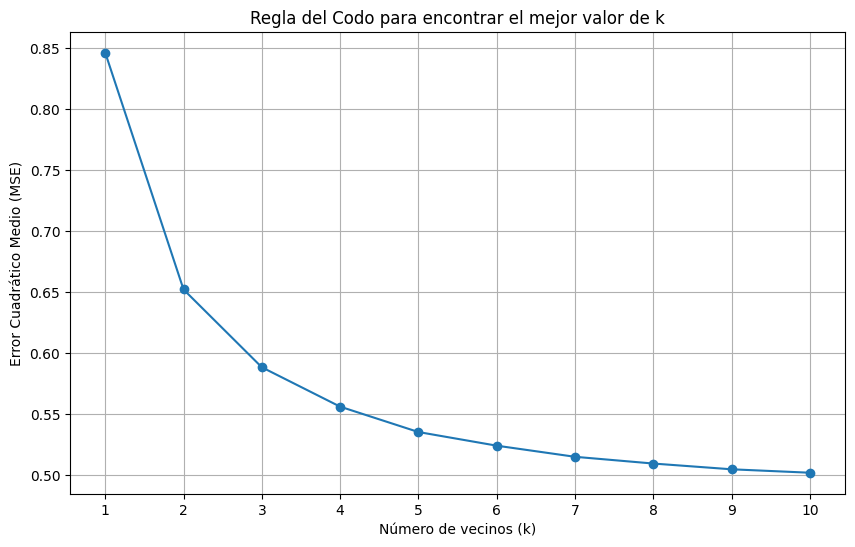

In [52]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_errors, marker='o')
plt.title('Regla del Codo para encontrar el mejor valor de k')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [53]:
df.loc[df['beds'] > df['accommodates'], 'accommodates'] = df['beds']

In [54]:
df.isnull().sum()   

id                                0
listing_url                       0
latitude                          0
longitude                         0
name                              0
host_id                           0
host_name                         0
host_url                          0
has_availability               4861
host_since                        0
neighbourhood_cleansed            0
room_type                         0
accommodates                      0
host_is_superhost                 0
bedrooms                          0
beds                              0
price                             0
minimum_nights                    0
maximum_nights                    0
number_of_reviews                 0
instant_bookable                  0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value         

In [55]:
df['has_availability'].fillna('f', inplace=True)

C:\Users\spide\AppData\Local\Temp\ipykernel_17068\237604420.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['has_availability'].fillna('f', inplace=True)


In [56]:
# Creamos la columna 'Sin review?' que más adelante nos servirá para clasificar los alojamientos con y sin review en un powerBI
df['Review?'] = df.apply(lambda row: 'Sin review' if all(row[variables_de_review.columns] == 0) else 'Con review', axis=1)

In [57]:
df['Review?'].value_counts()

Review?
Con review    68281
Sin review    27095
Name: count, dtype: int64

In [58]:
df[df['maximum_nights'] == df['maximum_nights'].max()][['listing_url','price','beds','accommodates','bedrooms','bathrooms','maximum_nights','has_availability','Review?']] 

,listing_url,price,beds,accommodates,bedrooms,bathrooms,maximum_nights,has_availability,Review?
1069,https://www.airbnb.com/rooms/1088383,113.0,1.0,2,1.0,1.0,2147483647,t,Con review


In [59]:
df.nlargest(20, 'maximum_nights')[['listing_url', 'price', 'beds', 'accommodates', 'bedrooms', 'bathrooms', 'maximum_nights', 'has_availability', 'Review?']]

,listing_url,price,beds,accommodates,bedrooms,bathrooms,maximum_nights,has_availability,Review?
1069,https://www.airbnb.com/rooms/1088383,113.0,1.0,2,1.0,1.0,2147483647,t,Con review
10652,https://www.airbnb.com/rooms/12501605,35.0,1.0,1,1.0,1.0,10000000,f,Sin review
18221,https://www.airbnb.com/rooms/23055173,537.0,4.0,8,3.0,2.0,1126,t,Con review
14,https://www.airbnb.com/rooms/11798,124.0,1.0,2,1.0,1.0,1125,t,Con review
35,https://www.airbnb.com/rooms/110322,160.0,5.0,5,2.0,1.0,1125,t,Con review
38,https://www.airbnb.com/rooms/114543,95.0,1.0,2,1.0,1.0,1125,t,Con review
41,https://www.airbnb.com/rooms/12887,67.0,1.0,2,1.0,1.0,1125,t,Con review
44,https://www.airbnb.com/rooms/17287,80.0,1.0,5,1.0,2.0,1125,t,Con review
45,https://www.airbnb.com/rooms/17316,150.0,1.0,2,1.0,1.0,1125,t,Sin review
50,https://www.airbnb.com/rooms/22158,150.0,1.0,2,1.0,1.0,1125,t,Con review


In [60]:
#borramos las filas con índices 1069 y 10652 por que tienen valores muy extremos de maximum_nights
df = df.drop([1069, 10652])

## Visualización general

### Histogramas

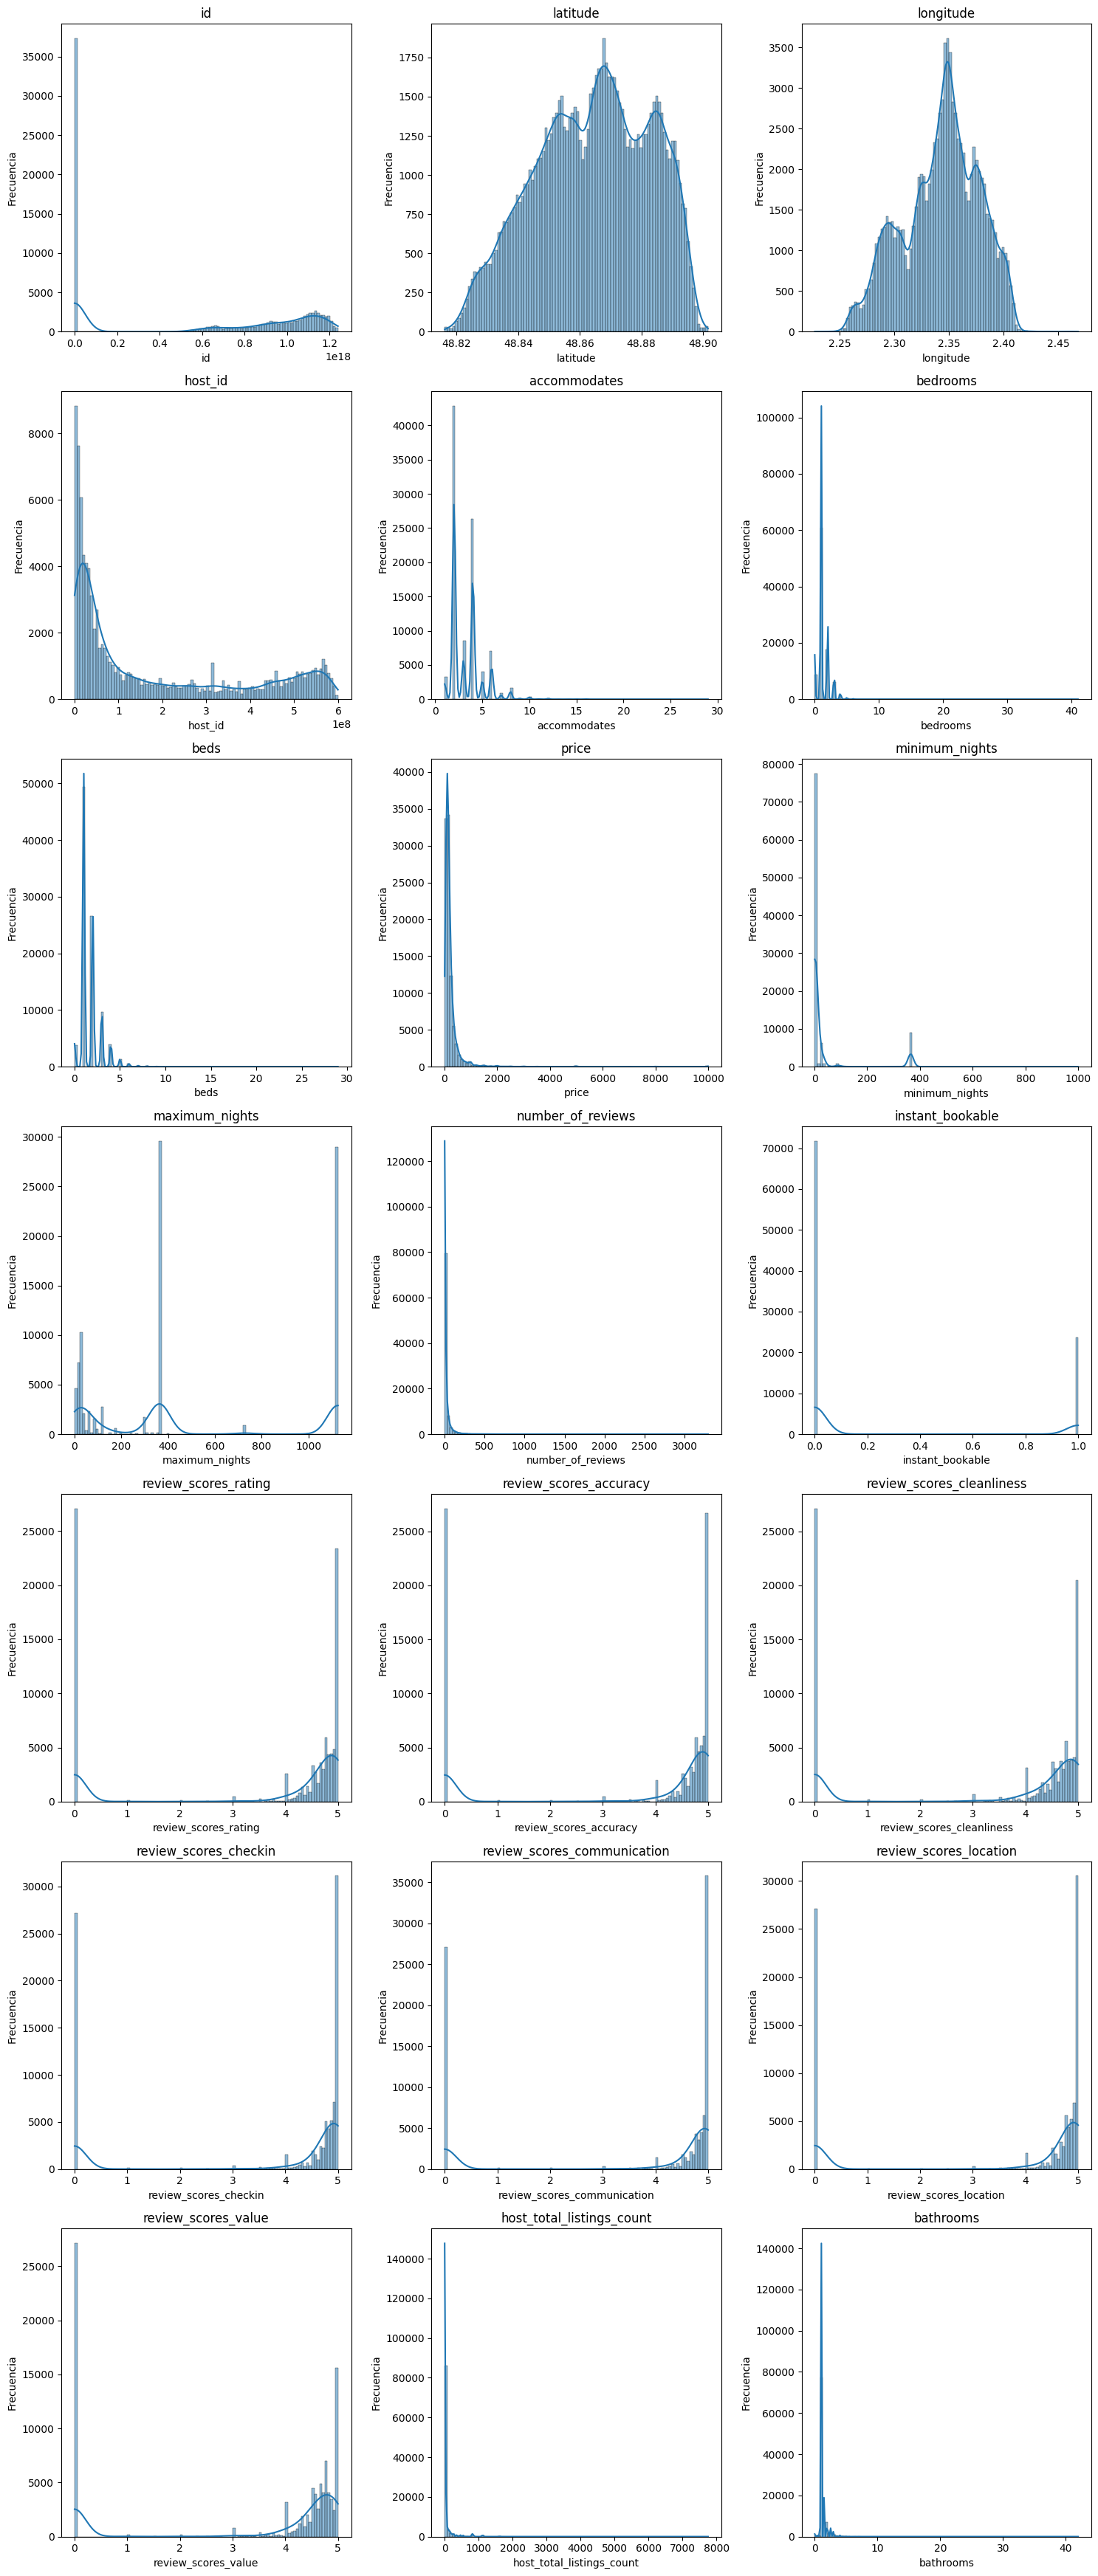

In [61]:

# Seleccionar las variables numéricas
num_vars = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar la figura y los subplots
n_cols = 3  # Número de columnas en la cuadrícula
n_rows = (len(num_vars) + n_cols - 1) // n_cols  # Calcula el número de filas necesario

plt.figure(figsize=(15, n_rows * 5))  # Ajustar el tamaño de la figura

# Iterar sobre las variables numéricas
for i, var in enumerate(num_vars):
    plt.subplot(n_rows, n_cols, i + 1)  # Crear un subplot
    sns.histplot(df[var], kde=True, bins=100)  # Crear histograma con KDE
    plt.title(var)  # Título del gráfico
    plt.xlabel(var)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y

plt.tight_layout()  # Ajustar diseño
plt.show()


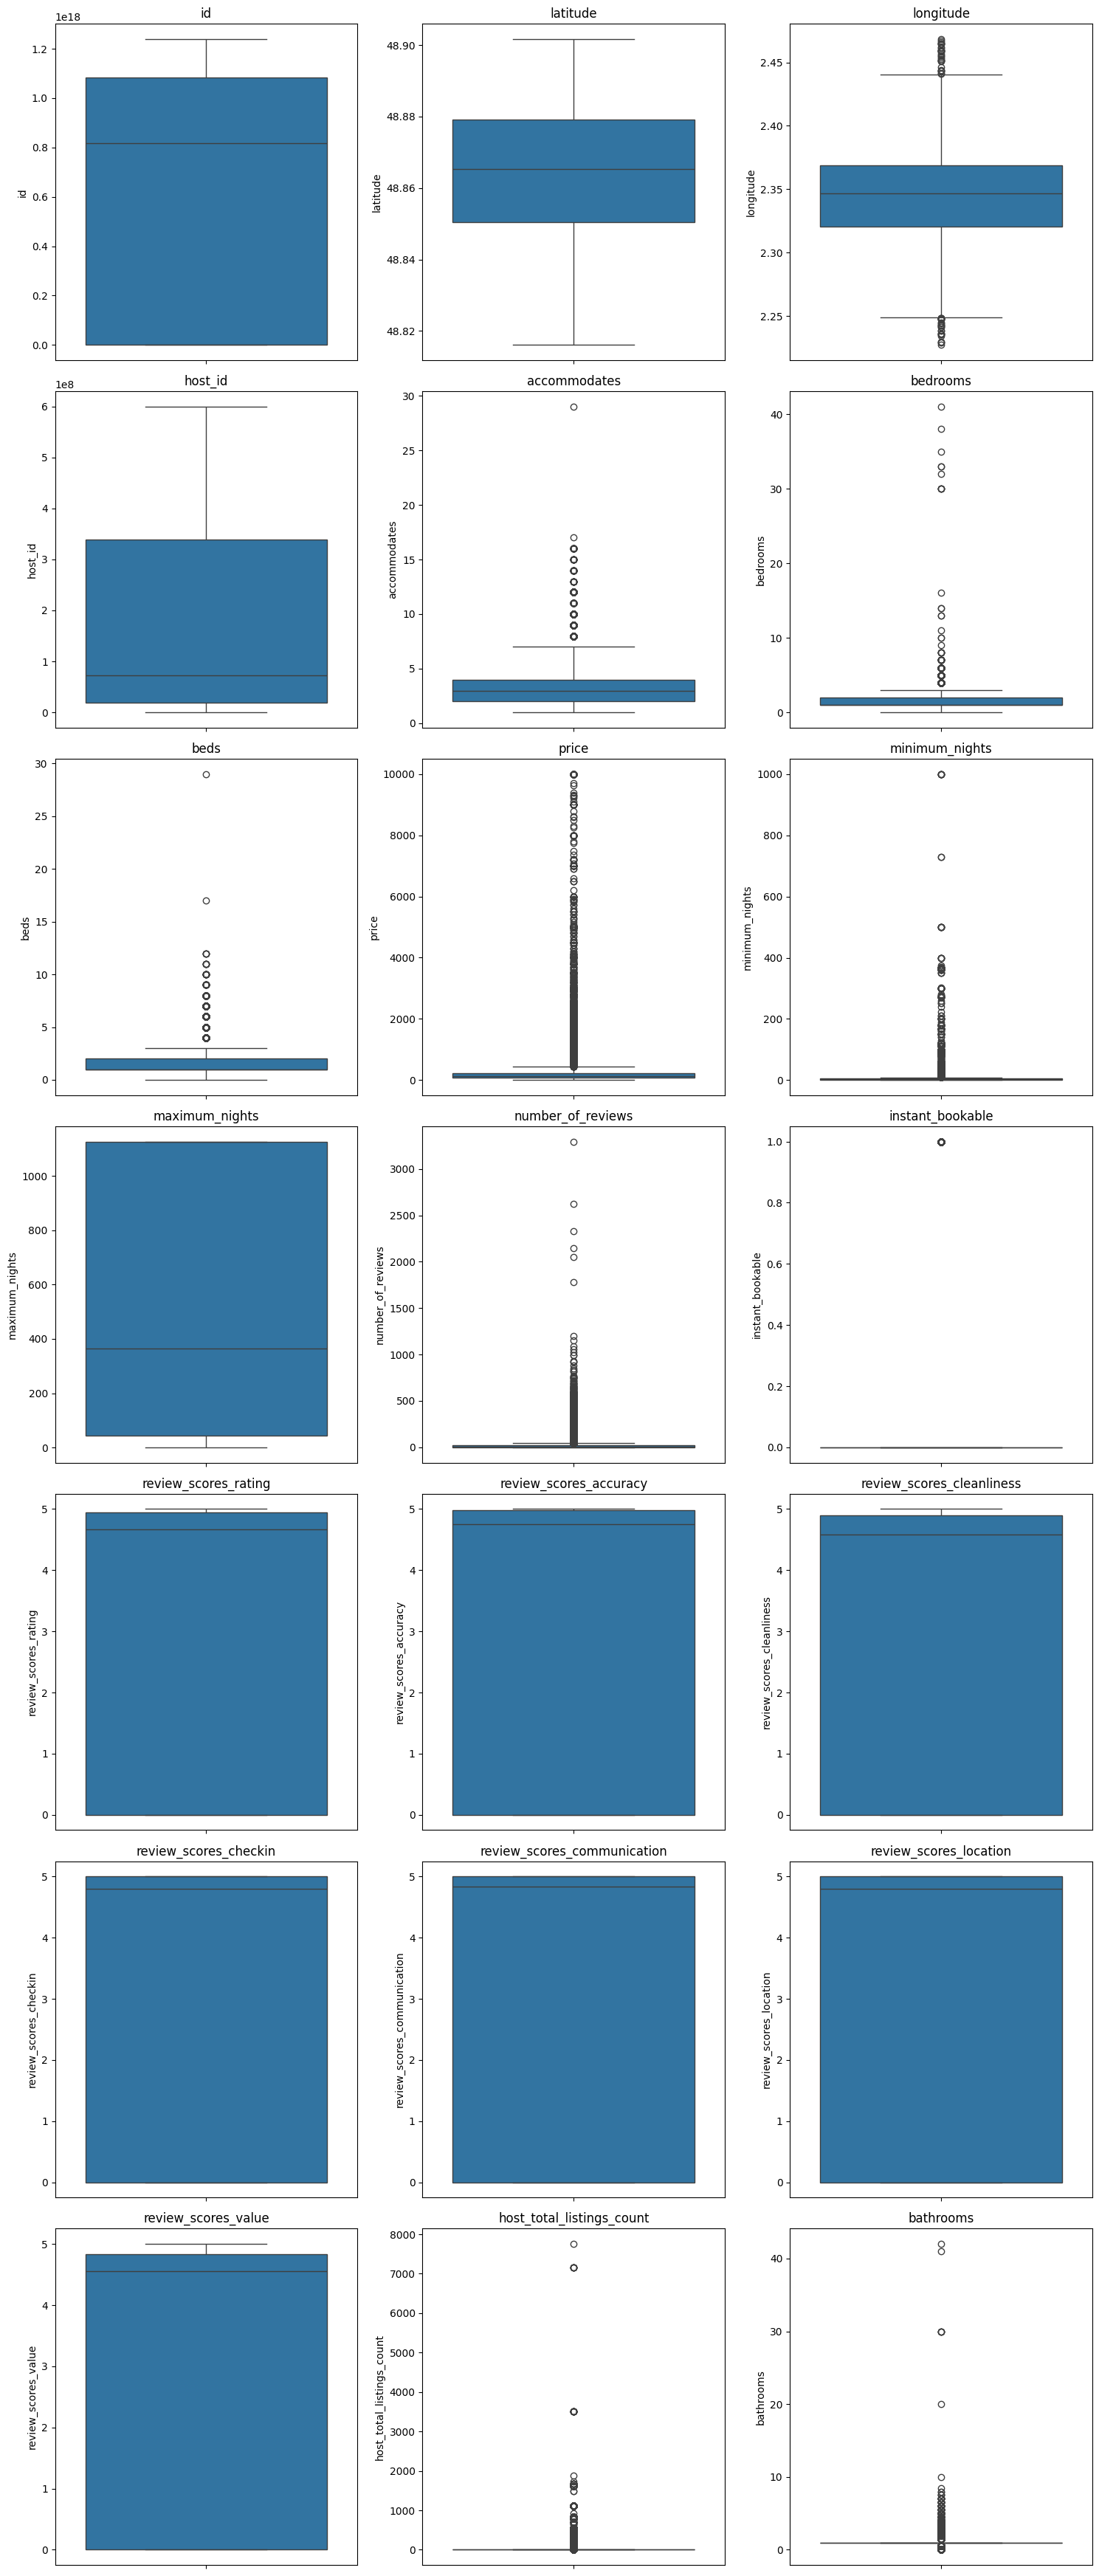

In [62]:
# Seleccionar las variables numéricas
num_vars = df.select_dtypes(include=['float64', 'int64']).columns

# Configurar la figura y los subplots
n_cols = 3  # Número de columnas en la cuadrícula
n_rows = (len(num_vars) + n_cols - 1) // n_cols  # Calcula el número de filas necesario

plt.figure(figsize=(15, n_rows * 5))  # Ajustar el tamaño de la figura

# Iterar sobre las variables numéricas
for i, var in enumerate(num_vars):
    plt.subplot(n_rows, n_cols, i + 1)  # Crear un subplot
    sns.boxplot(y=df[var],showfliers=True)  # Crear el boxplot para la variable
    plt.title(var)  # Título del gráfico
    plt.xlabel('')  # Quitar etiqueta del eje x para claridad

plt.tight_layout()  # Ajustar diseño
plt.show()

#NOTA: Hemos ocultado los outliers ya que se veían demasiados en variables como price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count y availability_365.

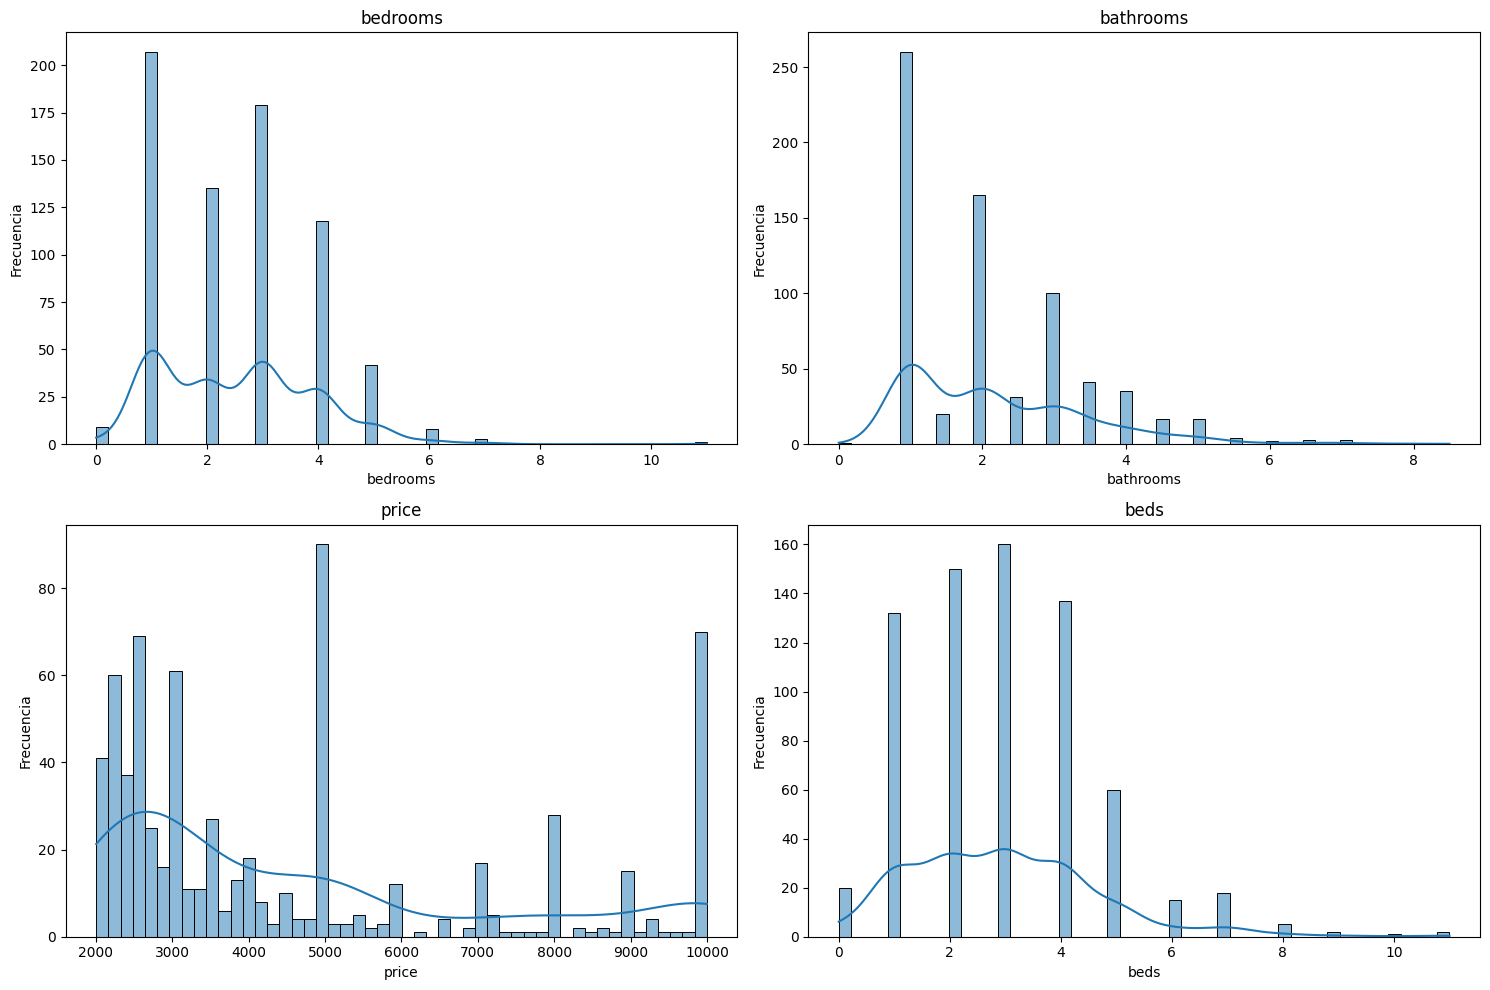

In [63]:
# Filtramos el df para cuando el precio es mayor a 2000
filtered_df = df[df['price'] > 2000]

# Queremos ver las columnas 'bedrooms', 'bathrooms', 'price' y 'beds'  
columns_of_interest = ['bedrooms', 'bathrooms', 'price', 'beds']
filtered_data = filtered_df[columns_of_interest]

# Configurar la figura y los subplots
plt.figure(figsize=(15, 10))  # Ajustar el tamaño de la figura

# Iterar sobre las columnas de interés y crear histogramas
for i, column in enumerate(columns_of_interest):
    plt.subplot(2, 2, i + 1)  # Crear un subplot
    sns.histplot(filtered_data[column], kde=True, bins=50)  # Crear histograma con KDE
    plt.title(column)  # Título del gráfico
    plt.xlabel(column)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y

plt.tight_layout()  # Ajustar diseño
plt.show()

In [64]:
'''Vemos que para valores muy elevados de price la gran mayoria de datos de beds, bathrooms y bedrooms están dentro
 del rango donde se observan más frecuencias, por lo que considero descartar estas filas de mi dataframe ya 
que pueden tratarse de errores de adquisición de datos y en total forman un 0.73% del conjunto de datos:'''

df = df[df['price'] <= 2000]

In [65]:
#veamos el outlier de beds > 25
df[df['beds'] >25][['listing_url', 'price', 'beds', 'accommodates', 'bedrooms', 'bathrooms', 'maximum_nights', 'has_availability', 'Review?']]

,listing_url,price,beds,accommodates,bedrooms,bathrooms,maximum_nights,has_availability,Review?
91198,https://www.airbnb.com/rooms/1191826870540505649,120.0,29.0,29,7.0,3.0,365,t,Sin review


Si te metes al link no aparece ningun alquiler pero bueno, no es descabellado que en 29 camas en 7 habitaciones, poodría tratarse de una casa de colonias

In [66]:
#Vemos lo mismo pero para el caso de bedrooms > 25
df[df['bedrooms'] > 25][['listing_url', 'price', 'beds', 'accommodates', 'bedrooms', 'bathrooms', 'maximum_nights', 'has_availability', 'Review?']]

,listing_url,price,beds,accommodates,bedrooms,bathrooms,maximum_nights,has_availability,Review?
16975,https://www.airbnb.com/rooms/21216654,65.0,1.0,2,32.0,1.0,30,t,Con review
19085,https://www.airbnb.com/rooms/24667815,441.0,3.0,3,38.0,1.0,1125,t,Sin review
30559,https://www.airbnb.com/rooms/43084931,175.0,1.0,2,33.0,1.0,7,t,Con review
30618,https://www.airbnb.com/rooms/43369014,140.0,1.0,1,33.0,1.0,10,t,Con review
54020,https://www.airbnb.com/rooms/913477855231933260,1000.0,3.0,16,41.0,41.0,365,t,Sin review
54253,https://www.airbnb.com/rooms/915706058772555776,580.0,3.0,16,30.0,30.0,365,t,Sin review
69649,https://www.airbnb.com/rooms/1071020436354803291,650.0,3.0,16,30.0,30.0,365,t,Sin review
69844,https://www.airbnb.com/rooms/1070865909210631354,625.0,3.0,16,30.0,30.0,365,t,Sin review
69926,https://www.airbnb.com/rooms/1070960072975209098,625.0,3.0,16,30.0,30.0,365,t,Sin review
93748,https://www.airbnb.com/rooms/1207869038224969936,159.0,1.0,2,35.0,42.0,5,t,Sin review


In [67]:
#Observamos que los valores de bedrooms en todos los casos son mayores que los accommodates, cosa que no tiene sentido así que d
#decidimos eliminarlos
df = df[df['bedrooms'] <= 25]


In [68]:
porcentaje_de_tabla_eliminado = 100-(df.shape[0]/listing.shape[0])*100
print(f'Porcentaje de tabla eliminado: {porcentaje_de_tabla_eliminado:.2f}')

Porcentaje de tabla eliminado: 0.84


In [69]:
# Convertimos nuestro df a un csv para empezar el EDA
df.to_csv('Airbnb_Paris.csv', index=False)